# Speech Recognition with PyTorch

Tensorflow recently released the Speech Command Dataset which are ~1 second long audio clips of a large number of unique individuals speaking one of 30 simple English language words. Ten of these words are simple voice commands: yes, no, on, off, right, left, up, down, stop, go. Here I explore a way of identifying which word is spoken in the audio clip.

In [1]:
import time 

import torch as t
import torch.autograd as ag
from torch.nn import functional as func
from torch.utils import data
import torch.optim as optim
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_style('white')
plt.rcParams['figure.figsize'] = (22, 9)
plt.rcParams['font.family'] = "DejaVu Sans"

%matplotlib inline 

Load some of the audio wav files with librosa, compute their Discrete Fourier Transform and plot the spectrograms to get a sense for the data. The audio files are close to 1 second long, for which, the following parameters produce a 513 x 101 dimension spectrograms.

In [2]:
def create_fft(fname):
    """Given an audio file, returns its spectrogram
    
    The function loads the audio file, with a sampling rate of 16 kHz,
    and performs a windowed fourier transform, with a window length of 640
    samples. The returned spectrum is a 2D map with time on the x-axis and
    frequency on the y-axis, with amplitube converted to decibels.
    """
    y, sr = librosa.load(fname, sr=16000)
    fourier_transform = librosa.core.stft(y, n_fft = 1024, win_length=640)
    D = librosa.amplitude_to_db(fourier_transform, ref=np.max)
    return D

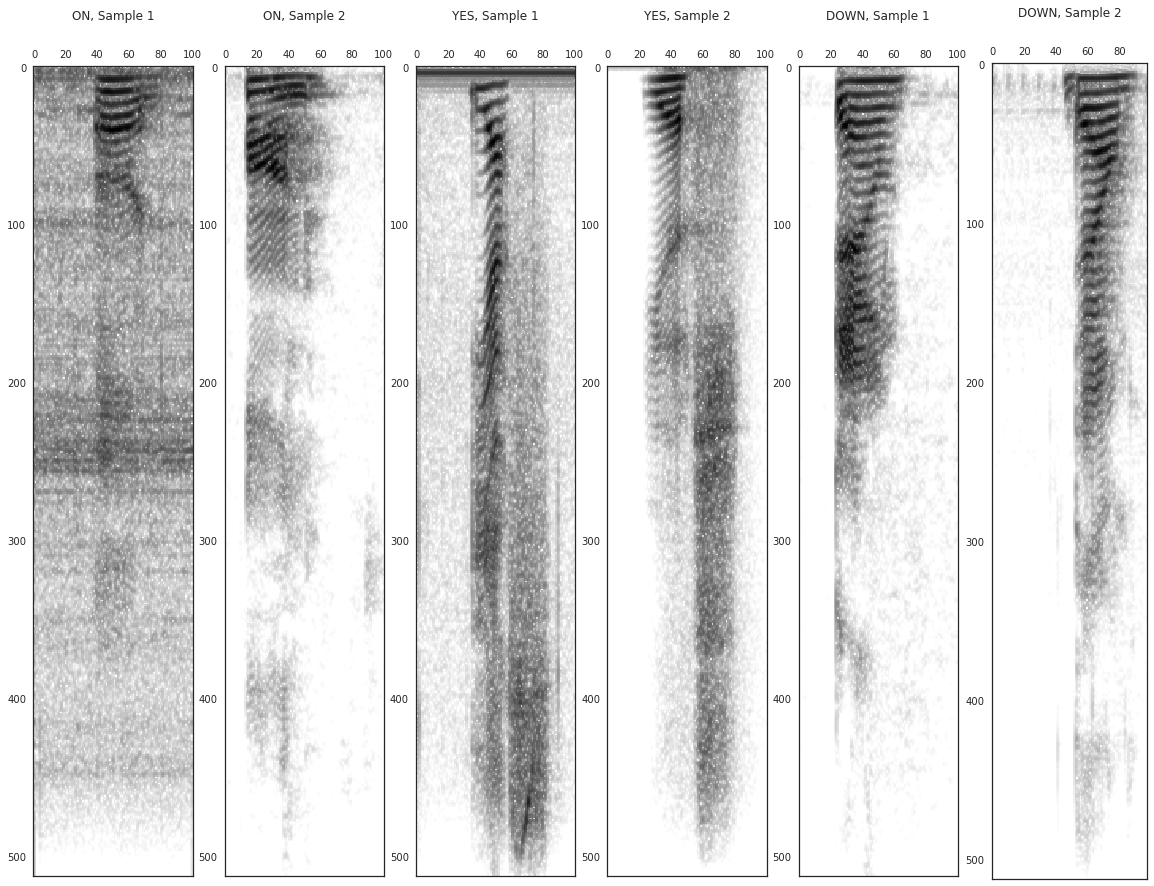

In [3]:
(fig, ax) = plt.subplots(1, 6, figsize=(20,15))

# plot the spectrogrmas for two audio clips of the word "ON"

D_on1 = create_fft("train/audio/on/5af0ca83_nohash_0.wav")
ax[0].matshow(D_on1)
ax[0].set_title("ON, Sample 1")

D_on2 = create_fft("train/audio/on/49af4432_nohash_1.wav")
ax[1].matshow(D_on2)
ax[1].set_title("ON, Sample 2")

# plot the spectrogrmas for two audio clips of the word "YES"

D_yes1 = create_fft("train/audio/yes/7cb5c0b7_nohash_0.wav")
ax[2].matshow(D_yes1)
ax[2].set_title("YES, Sample 1")

D_yes2 = create_fft("train/audio/yes/dec73123_nohash_0.wav")
ax[3].matshow(D_yes2)
ax[3].set_title("YES, Sample 2")

# plot the spectrogrmas for two audio clips of the word "DOWN"

D_down1 = create_fft("train/audio/down/953fe1ad_nohash_2.wav")
ax[4].matshow(D_down1)
ax[4].set_title("DOWN, Sample 1")

D_down2 = create_fft("train/audio/down/41dce6f5_nohash_0.wav")
ax[5].matshow(D_down2)
ax[5].set_title("DOWN, Sample 2")


The spectrograms for the same words show similar features that are distinct from features which characterize a different word. This indicates that there may be enough information in the spectrogram to recognize the spoken word.

CNN's have been shown to be quite successful at [keyword spotting](http://www.isca-speech.org/archive/interspeech_2015/papers/i15_1478.pdf).  Here, I create a convolutional neural network to infer the word based on the 2D spectrogram image. 
The network contains 2 convolutional layers. The first applies 10 x 6 convolutions with stride 1 to produce 16 feature maps. The output from this layer is max-pooled with a size 3 x 3 and passed to the second convolutional layer. This layer applies 4 x 3 convolutions and produces 64 feature maps that are also max-pooled with a 3 x 3 size. The network then contains two fully connected layers composed of rectified linear units and a final softmax output layer with 10 units, each one corresponding to one of the 10 target command words.

Here's a PyTorch implementation of this network.

In [4]:
class Net(t.nn.Module):
    """A class to define the CNN model architecture"""
    
    def __init__(self):
        """Initializes the Net with  2 convolution layers and 3 dense layers"""
        super(Net, self).__init__()
        
        # input size 513 x 101
        # 1 input channel
        # 6 output channels, or convolution kernels
        # 10x6 square convlutions
        self.conv1 = t.nn.Conv2d(1, 16, (10, 6))
        # output size 504 x 96 x 16
        
        # second convolution layer
        # input size 168 x 32
        self.conv2 = t.nn.Conv2d(16, 64, (4, 3))
        # output size 165 x 30
        
        # input size 55 x 10 x 64
        # define fully connected, linear layers
        self.fc1 = t.nn.Linear(55 * 10 * 64, 128)
        self.fc2 = t.nn.Linear(128, 96)        
        self.fc3 = t.nn.Linear(96, 10)

        
    def forward(self, x):
        """Makes a forward pass on the data"""
        # (2,2) max-pooling of the first convolutional layer
        x = func.max_pool2d(func.relu(self.conv1(x)), 3)
        
        x = func.max_pool2d(func.relu(self.conv2(x)), 3)
        
        # flatten the 2D convolutions to a a 1D vector         
        x = x.view(-1, self.num_flat_features(x))        
        x = func.dropout(x, p=0.4)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
 

    def num_flat_features(self, x):
        """A quick function to help flatten the input to the dense layers"""
        # the first number in the size is the size of 
        # the batch. We don't care about that for this
        x_size = x.size()[1:]
        
        num_features = 1
        for s in x_size:
            num_features *= s
        
        return num_features

    
net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 16, kernel_size=(10, 6), stride=(1, 1))
  (conv2): Conv2d (16, 64, kernel_size=(4, 3), stride=(1, 1))
  (fc1): Linear(in_features=35200, out_features=128)
  (fc2): Linear(in_features=128, out_features=96)
  (fc3): Linear(in_features=96, out_features=10)
)


The following class inherits from PyTorch Dataset classes and handles the data processing before handing off to the network. The audio file names and labels are stored in a pandas dataframe. The spectrogram for a given file is only created when the file is in a batch requested by the network. This helps keep the memory usage manageable.

Some of the files are shorter than the 101 length of the full 1 second long files. In that case, I zero pad at the end. If the file is longer than a second, then I just drop the last few time bins from the spectrogram.

For simplicity, I am ignoring all the other words and recordings of silence (background noise) and just exposing the network to the 10 speech commands. 

In [5]:
# list all the words we are trying to identify. Will be useful in generating the labels for the audio files
label_map = ('yes', 'no', 'up', 'down', 'left',  'right', 'on', 'off', 'stop', 'go')
nclasses = len(label_map)
print("number of classes: ", nclasses)


class AudioDataset(t.utils.data.Dataset):
    """Creates a dataset of audio files and creates spectrograms to deliver to the network"""
    
    def __init__(self, file, frac=0.2):
        """Initialize AudioDataset by creating a pandas dataframe to keep track of audio files"""
        self.file = file
        self.df = pd.read_csv(self.file, header=None, names=['file'])
        self.parse_df()
        # Forget about silence and other categories for now.
        self.df = self.df[(self.df.label != 11) & (self.df.label != 10)].copy().reset_index(drop=True)
        self.df = self.df.sample(frac=frac).reset_index(drop=True)
        
    def __len__(self):
        """Returns the number of samples in the dataset"""
        return len(self.df)
    

    def __getitem__(self, idx):        
        """Returns a data item at index idx"""
        spec = self.create_spectrogram(self.df.loc[idx].file)
        label  = self.df.loc[idx].label
        return spec, label
 

    def create_spectrogram(self, fname): 
        """Creates a spectrogram and adjusts its dimensions to be 513 X 101"""
        D = create_fft("train/audio/" + fname)
        length = D.shape[1]
        
        if length > 101:
            # this is a silence file. Sample
            rnum = np.random.randint(0, length-101)            
            D = D[:, rnum:rnum+101]
        else:
            # file is shorter, 0 pad.
            nzeroes = 101-length
            pad = np.array([[0]*nzeroes]*D.shape[0])
            D = np.append(D, pad, axis=1)
        D = D[np.newaxis,:,:]
        return t.from_numpy(D).float()
    
    
    def parse_df(self):
        """Create numeric labels for the command words"""
        labels = []
        
        for i in range(len(self.df)):
            line = self.df.loc[i].file     
            words = line.split('/')
                
            if words[0] in label_map:
                labels.append(label_map.index(words[0]))
                
            elif words[0] == '_background_noise_':
                labels.append(10)
            else:
                labels.append(11)
                        
        self.df['label'] = labels
        return



number of classes:  10


Load the training and test datasets. The train-test split is the same as Tensorflow's split in their [Kaggle competition](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge) based on this dataset. The training set contains a little over 18k audio files for the 10 voice command words, and the test set has close to 7k files.

Also make a random 40% subset of the training dataset that we can use to monitor the performance of the network at the end of each epoch.

The files in the datasets are delivered in batches of 100.

In [6]:
# Create train, test and train subset datasets
trainds = AudioDataset('train/training_list.txt', frac = 1.0)
testds = AudioDataset('train/testing_list.txt', frac = 1.0)
trainds_subset = AudioDataset('train/training_list.txt', frac = 0.4)

# Create data loaders for the above datasets
trainloader = t.utils.data.DataLoader(trainds, shuffle=True, batch_size=100);
testloader  = t.utils.data.DataLoader(testds, shuffle=True, batch_size=100);
trainloader_subset = t.utils.data.DataLoader(trainds_subset, shuffle=True, batch_size=100);


The network is trained to minimize the cross-entropy loss criterion using Adam optimizer.

In [7]:
criterion = t.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Define a function to test the model performance. It prints out the classification accuracy for each of the 10 words.

In [9]:
def test_net(loader):
    """Computes the accuracy of the netword for each command word"""
    tot = np.zeros(nclasses)
    acc = np.zeros(nclasses)
    for (spec, label) in loader:
        output = net(ag.Variable(spec))
        _, pred = t.max(output.data, 1)
        for i in range(len(pred)):
            tot[label[i]] += 1
            if pred[i] == label[i]:
                acc[label[i]] += 1
    tpr = acc / tot
    print(tpr)
    return np.sum(acc) / np.sum(tot)

Train the model on the training dataset for 20 epochs. At the end of each epoch, test the model performance on the test set as well as a subset of the training set, so we can see if the model is generalizing well.
Report the loss after every 40 batches.

In [8]:
report_interval = 40
test_acc = []
train_acc = []

start = time.time()
for epoch in range(20):
    run_loss = 0.0
    for (i, (inputs, labels)) in enumerate(trainloader, 0):
        # Cast the spectrograms and the labels as tensors                 
        inputs, labels = ag.Variable(inputs), ag.Variable(labels)        
        optimizer.zero_grad()        
        outputs = net(inputs)
        
        # Compute the loss and the gradients and update the weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # keep track of the loss so it can be reported in a printout
        run_loss += loss.data[0]
        if (i + 1) % report_interval == 0:
            print('[{}s]: epoc {}, minibatch {}, loss {}'.format(time.time() - start, epoch + 1, i, run_loss / report_interval))
            run_loss = 0.0
        
    test_acc.append(test_net(testloader))
    train_acc.append(test_net(trainloader_subset))
    
print("Done training")

[80.92692756652832s]: epoc 1, minibatch 39, loss 5.4068991959095
[160.64262008666992s]: epoc 1, minibatch 79, loss 1.7898842930793761
[238.7261769771576s]: epoc 1, minibatch 119, loss 1.2185855865478517
[318.2448379993439s]: epoc 1, minibatch 159, loss 0.9553546190261841
[ 0.8984375   0.50793651  0.64338235  0.55731225  0.47191011  0.7953668
  0.79674797  0.79770992  0.76305221  0.78486056]
[ 0.92069892  0.53005464  0.6962677   0.63866667  0.58402204  0.854083
  0.80245232  0.82524272  0.79012346  0.81192053]
[580.3241353034973s]: epoc 2, minibatch 39, loss 0.6802202098071575
[658.7527277469635s]: epoc 2, minibatch 79, loss 0.6418778717517852
[737.2397933006287s]: epoc 2, minibatch 119, loss 0.5995913773775101
[816.6552667617798s]: epoc 2, minibatch 159, loss 0.5440730363130569
[ 0.83984375  0.64285714  0.88970588  0.77865613  0.71161049  0.8957529
  0.86178862  0.82061069  0.90361446  0.64541833]
[ 0.89247312  0.74863388  0.89060489  0.85333333  0.80991736  0.95180723
  0.88692098  0.

Plot the accuracy for the train and test datasets as a function of epoch

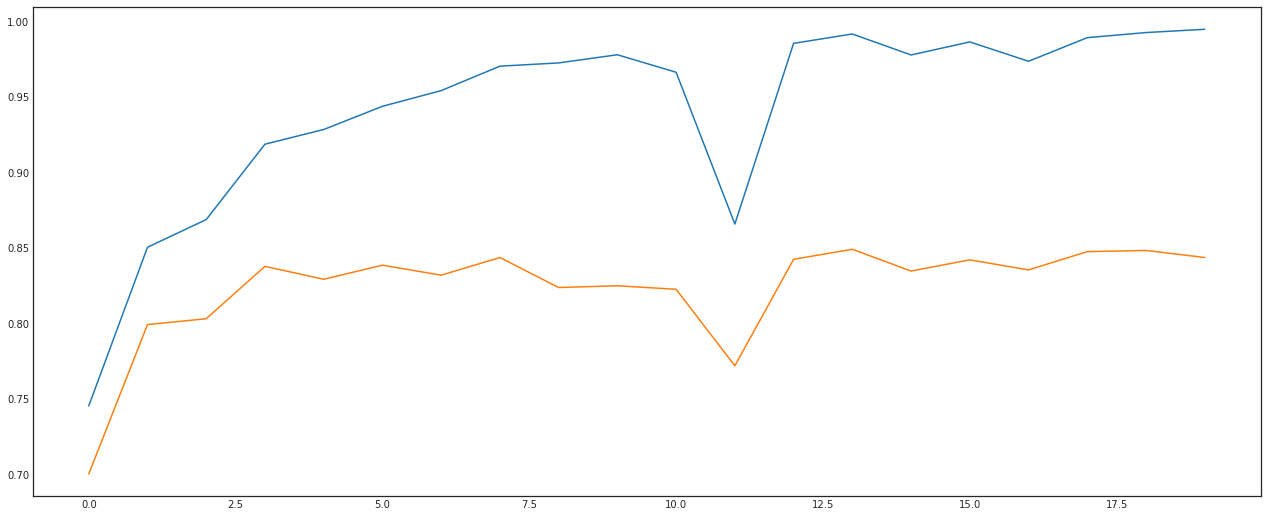

In [9]:
# Plot the train and test accuracies as a function of epoch number
plt.plot(train_acc)
plt.plot(test_acc)

First, the mean accuracy for the training set is close to 1 and still rising at the end of the 20th epoch. 
The performance on the test dataset is good, but not really comparable to the performance of the training set. Morover, the accuracy seems to have plateaued for the test set. This indicates that the model is over-fitting and warrants some stronger form of regularization.

Let's have a look at the confusion matrix for the test set.

In [14]:
def confusion_matrix(loader):
    """Creates a confusion matrix of predicted labels vs the true labels"""
    mat = np.zeros((nclasses, nclasses))
    for (spec, label) in loader:
        output = net(ag.Variable(spec))
        _, pred = t.max(output.data, 1)
        for i in range(len(pred)):
            mat[pred[i]][label[i]] += 1
    return mat

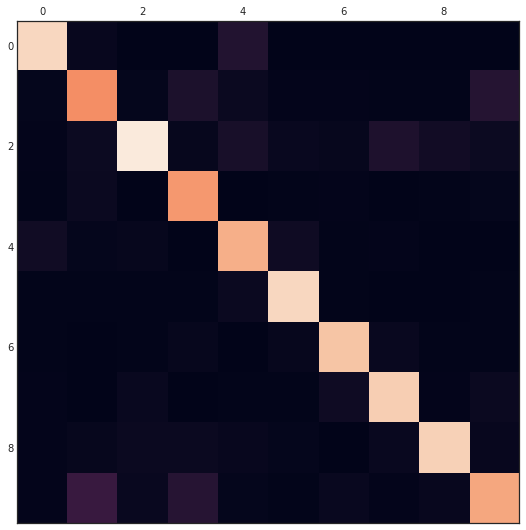

In [15]:
# Plot the confusion matrix
mat = confusion_matrix(testloader)
plt.matshow(mat)

This looks highly diagonal, which is good. Looks like the words No and Go are being confused with each other, which is not very surprising- they're both short words with similar structure. Interestingly, Down is being confused for Go quite frequently too!

# Conclusion

The model's accuracy for the test set is around 80%. I am considering a much simpler problem here (completely ignoring words other than the 10 voice commands and silence) yet the performance is quite a lot worse than the best performing networks in the Kaggle competition which have accuracies upwards of 91%. There's a lot of room for improvement here.
The accuracy of this network for the training set is close to 100%, which suggests that the network has enough capacity. However, the generalization gap is nearly 20%! The model needs stronger regularization which can be introduced perhaps in the form of higher probability dropouts. The performance could also improve by using a different representation of the data, eg: using Mel frequency cepstrum coefficiencts.